## Cyclicals
### Summary 

With growing focus on cyclical asset recovery and a still very easy stance from the Fed, the short USD theme has gotten renewed attention from the investor community.

In the analysis below, we look at G10 currencies' correlation to risk (proxied by SPX) and volatility and find that NOK offers both high exposure to a continued risk-on rally with cheap tails compared to peers.

P.S. Missed our webcast? [Click here](https://developer.gs.com/docs/gsquant/videos/gs-quant-meets-markets-nov/) for a replay that touches on this theme. Also checkout [this note](https://marquee.gs.com/content/markets/en/2020/11/25/bbe0fca7-c70b-4c92-a0f3-22880574d957.html) from Brian Friedman for specific implementations of this theme.

The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Find cyclical crosses](#2---Find-cyclical-crosses)
* [3 - Solve for best expression](#3---Solve-for-best-expresion)
* [What's New](#What's-New)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.227.

In [1]:
from gs_quant.session import GsSession
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',)) 

### 2 - Find cyclical crosses

Let's start by looking for crosses that are most sensitive to risk. To do that, we use SPX returns as the risk proxy and look at the YTD relationship of each cross' weekly returns to SPX's. We pull the FX spot data from FRED ([create token here](https://research.stlouisfed.org/docs/api/api_key.html) if you don't have one), downsample data from daily to weekly and calculate returns at a first step. FX spot also available via [gs data catalog](https://marquee.web.gs.com/s/developer/datasets/FXSPOT_PREMIUM/connect).

In [2]:
from gs_quant.data import Dataset
from gs_quant.api.fred.data import FredDataApi
from gs_quant.timeseries import returns
from datetime import date
import pandas as pd
pd.set_option('display.precision', 2)

data = {'SPX': 'SP500', 'EUR': 'DEXUSEU', 'JPY': 'DEXJPUS', 'AUD': 'DEXUSAL', 'GBP': 'DEXUSUK', 'CAD': 'DEXCAUS',
       'NOK': 'DEXNOUS', 'CHF': 'DEXSZUS', 'SEK': 'DEXSDUS', 'NZD': 'DEXUSNZ'}
pairs = {'EUR': 'EURUSD', 'JPY': 'USDJPY', 'AUD': 'AUDUSD', 'GBP': 'GBPUSD', 'CAD': 'USDCAD', 'NOK': 'USDNOK',
        'CHF': 'USDCHF', 'SEK': 'USDSEK', 'NZD': 'NZDUSD'}

FRED_API_KEY = 'YOUR_KEY_HERE'
fred_API = FredDataApi(api_key=FRED_API_KEY)
df = pd.concat([Dataset(symbol, fred_API).get_data(date(2020, 1, 1)) for n, symbol in data.items()], axis=1)
df.columns = data.keys()
# let's flip these to look at all relative to USD
df = df.apply(lambda x: 1/x if x.name in ['JPY', 'CAD', 'SEK', 'NOK', 'CHF'] else x)
rets = returns(df.resample('W-FRI').last(), 1).dropna()
rets.head(3) * 100

,SPX,EUR,JPY,AUD,GBP,CAD,NOK,CHF,SEK,NZD
date,,,,,,,,,,
2020-01-10,0.94,-0.48,-1.42,-0.86,-0.24,-0.51,-0.76,-0.27,-1.26,-0.51
2020-01-17,1.97,-0.23,-0.60,-0.38,-0.24,-0.18,-0.31,0.48,-0.11,-0.44
2020-01-24,-1.03,-0.60,0.78,-0.77,0.32,-0.55,-1.39,-0.30,-0.53,-0.12


With the data in hand, let's look at the relationship of SPX to the other pairs in order of the highest r-squared which represent the strongest relationship to SPX. 

<AxesSubplot:title={'center':'YTD R^2 with SPX'}>

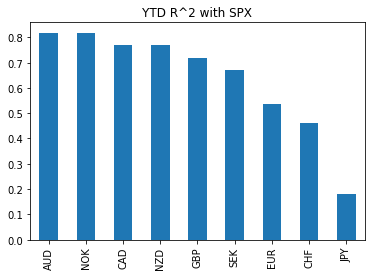

In [3]:
from scipy.stats import pearsonr

crosses = list(pairs.keys())
r2 = pd.Series({i: pearsonr(rets.SPX, rets[i])[0] for i in crosses}, name='R2').sort_values(ascending=False)
r2.plot(kind='bar', title='YTD R^2 with SPX')

As we can see above, AUD, NOK and CAD have the top 3 highest correlations to SPX YTD.

To visually confirm that the relationship is not driven by tail events let's look at a scatter; returns on weeks where SPX has realized greater or less than 10% are denoted in green and red, respectively. The below confirms the relationship still holds especially for the top 3 crosses.

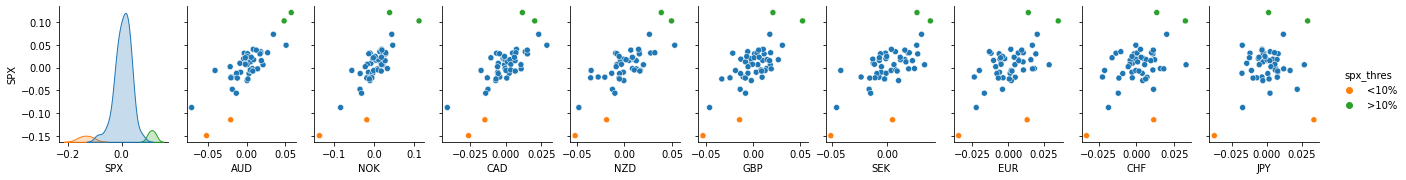

In [4]:
import seaborn as sns

rets['spx_thres'] = rets.SPX.apply(lambda x: '>10%' if x >=.1 else '<10%' if x <=-.1 else '')
sns.pairplot(rets, y_vars=['SPX'], x_vars=r2.keys().insert(0, 'SPX'), hue='spx_thres', aspect=.75)

### 3 - Solve for Best Expression

Now let's see how far out-of-the-money we need to strike binaries to express a short dollar view and get a 10x payout (note - you can use any ratio below). P.S. You can find more screens like this in our brand new [reports and screens folder](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/content/reports_and_screens).

In [5]:
from gs_quant.markets import PricingContext
from gs_quant.markets.portfolio import Portfolio
from gs_quant.instrument import FXBinary
from gs_quant.risk import FXSpot

payout_ratio = '10%'

binaries = Portfolio([FXBinary(pair=cross, expiration_date='3m', option_type='Put' if cross[:3]=='USD' else 'Call', 
                               strike_price=f'p={payout_ratio}', premium=0, name=ccy) for ccy, cross in pairs.items()])
with PricingContext():   
    binaries.resolve()
    spot = binaries.calc(FXSpot)

In [6]:
from gs_quant.timeseries import volatility

bf = binaries.to_frame()
bf.index = bf.index.droplevel(0)
bf = bf[['pair', 'option_type', 'strike_price']]
bf['ccy'] = [x.name for x in bf.index]
bf['spot'] = list(spot)

vols = pd.Series({ccy: volatility(row, len(row) - 1).iloc[0] for ccy, row in df.iteritems()}, name='realized_vol')
bf = pd.concat([bf.set_index('ccy'), r2, vols], axis=1).dropna()
bf['% otms'] = abs(bf.strike_price/bf.spot - 1) * 100 
bf['% otms (vol norm)'] =  bf['% otms'] / bf['realized_vol']

bf.set_index(['pair']).sort_values(by=['% otms (vol norm)']).style.background_gradient(subset=['% otms (vol norm)'])

,option_type,strike_price,spot,R2,realized_vol,% otms,% otms (vol norm)
pair,,,,,,,
USD NOK,OptionType.Put,8.27,8.84,0.82,18.18,6.43,0.35
USD CAD,OptionType.Put,1.25,1.30,0.77,8.48,3.79,0.45
USD SEK,OptionType.Put,8.08,8.50,0.67,11.01,4.99,0.45
AUD USD,OptionType.Call,0.78,0.74,0.82,13.02,5.95,0.46
NZD USD,OptionType.Call,0.75,0.70,0.77,13.03,5.98,0.46
GBP USD,OptionType.Call,1.41,1.33,0.72,11.19,5.34,0.48
USD JPY,OptionType.Put,99.78,104.00,0.18,8.49,4.06,0.48
USD CHF,OptionType.Put,0.87,0.90,0.46,7.43,3.93,0.53
EUR USD,OptionType.Call,1.25,1.20,0.53,7.56,4.33,0.57


Now, let's plot R-sq vs how far out of the money we need to strike to get a 10x payout. The most attractive trades will be in the top left: crosses that have the highest R^2 and are not as far otm (in green). As we can see below, USDNOK stands out as the best 10x binary implementation of this cyclical theme.

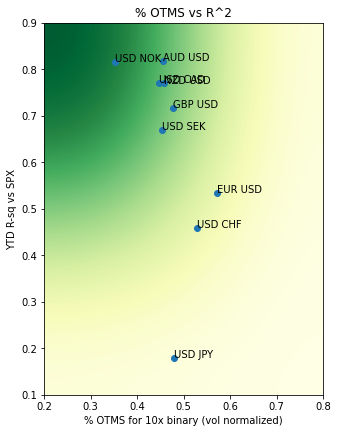

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow([[.5, 0], [0, 0]], cmap=plt.cm.YlGn, interpolation='bicubic', extent=[.2, .8, .1, .9])
ax.scatter(bf['% otms (vol norm)'], bf['R2'])
plt.title('% OTMS vs R^2')
plt.xlabel('% OTMS for 10x binary (vol normalized)')
plt.ylabel('YTD R-sq vs SPX')
for i, row in bf.iterrows():
    ax.annotate(row.pair, (row['% otms (vol norm)'], row['R2']))

### What's New
  * Check out [the content from our recent event](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/content/events/00_gsquant_meets_markets/01_ideas_for_risk_re_rating/) focused on ideas for vaccine risk re-rating
  * *New* [Reports and Screens](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/tree/master/gs_quant/content/reports_and_screens) content - please share your feedback on screens you'd like to see
  * *New* index curve shift scenario,  [example here](https://nbviewer.jupyter.org/github/goldmansachs/gs-quant/blob/master/gs_quant/documentation/02_pricing_and_risk/01_scenarios_and_contexts/tutorials/Scenarios.ipynb)